In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install torch torchvision torchaudio matplotlib pandas tqdm --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data load

In [ ]:
train_path = '/content/drive/MyDrive/merged_training.csv'
test_path = '/content/drive/MyDrive/merged_testing.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [ ]:
train_df = train_df.rename(columns={'M_value': 'M', 't_value': 't', 'y': 'S'})
test_df = test_df.rename(columns={'M_value': 'M', 't_value': 't', 'y': 'S'})

## Normalisation input data (x, t, M)

In [ ]:
x_min, x_max = train_df['x'].min(), train_df['x'].max()
t_min, t_max = train_df['t'].min(), train_df['t'].max()
M_min, M_max = train_df['M'].min(), train_df['M'].max()

for df in [train_df, test_df]:
    df['x_norm'] = (df['x'] - x_min) / (x_max - x_min)
    df['t_norm'] = (df['t'] - t_min) / (t_max - t_min)
    df['M_norm'] = (df['M'] - M_min) / (M_max - M_min)

def to_tensor(df):
    return (
        torch.tensor(df['x_norm'].values.reshape(-1,1), dtype=torch.float32, device=device),
        torch.tensor(df['t_norm'].values.reshape(-1,1), dtype=torch.float32, device=device),
        torch.tensor(df['M_norm'].values.reshape(-1,1), dtype=torch.float32, device=device),
        torch.tensor(df['M'].values.reshape(-1,1), dtype=torch.float32, device=device),
        torch.tensor(df['S'].values.reshape(-1,1), dtype=torch.float32, device=device)
    )

x_train, t_train, M_train_norm, M_train_phys, S_train = to_tensor(train_df)
x_test, t_test, M_test_norm, M_test_phys, S_test = to_tensor(test_df)

## Define models

In [ ]:
class PINN_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        D = 50
        self.net = nn.Sequential(
            nn.Linear(3, D), nn.Tanh(),
            nn.Linear(D, D), nn.Tanh(),
            nn.Linear(D, D), nn.Tanh(),
            nn.Linear(D, 1)
        )
    def forward(self, x, t, M):
        xtm = torch.cat([x, t, M], dim=1)
        return self.net(xtm)

class PIANN(nn.Module):
    def __init__(self):
        super().__init__()
        D = 50
        self.net = nn.Sequential(
            nn.Linear(3, D), nn.Tanh(),
            nn.Linear(D, D), nn.Tanh(),
            nn.Linear(D, D), nn.Tanh(),
            nn.Linear(D, 1)
        )
    def forward(self, x, t, M):
        xtm = torch.cat([x, t, M], dim=1)
        return self.net(xtm)

pinn = PINN_MLP().to(device)
piann = PIANN().to(device)

epochs = 100
batch_size = 256
learning_rate = 5e-3
patience_es = 7
patience_lr = 3

opt_pinn = torch.optim.Adam(pinn.parameters(), lr=learning_rate)
opt_piann = torch.optim.Adam(piann.parameters(), lr=learning_rate)

scheduler_pinn = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_pinn, mode='min', patience=patience_lr, factor=0.5, verbose=True)
scheduler_piann = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_piann, mode='min', patience=patience_lr, factor=0.5, verbose=True)

best_loss_pinn = np.inf
best_loss_piann = np.inf

early_stop_counter_pinn = 0
early_stop_counter_piann = 0

N = x_train.shape[0]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training PINN

In [ ]:
print("Training PINN...")

best_loss_pinn = np.inf
early_stop_counter_pinn = 0

for epoch in range(epochs):
    pinn.train()
    epoch_loss = 0
    perm = torch.randperm(N)

    batch_iter = range(0, N, batch_size)
    with tqdm(batch_iter, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as tepoch:
        for i in tepoch:
            idx = perm[i:i+batch_size]
            x_b, t_b, M_b, M_phys, S_b = (x_train[idx], t_train[idx], M_train_norm[idx], M_train_phys[idx], S_train[idx])
            x_b.requires_grad_()
            t_b.requires_grad_()

            pred = pinn(x_b, t_b, M_b)
            loss_data = nn.MSELoss()(pred, S_b)

            S_sum = pred.sum()
            S_t = torch.autograd.grad(S_sum, t_b, create_graph=True)[0]

            f = pred**2 / (pred**2 + M_phys * (1 - pred)**2 + 1e-8)
            f_sum = f.sum()
            f_x = torch.autograd.grad(f_sum, x_b, create_graph=True)[0]

            residual = S_t + f_x
            loss_phys = nn.MSELoss()(residual, torch.zeros_like(residual))

            loss = loss_data + loss_phys
            opt_pinn.zero_grad()
            loss.backward()
            opt_pinn.step()
            epoch_loss += loss.item()

            tepoch.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / (N // batch_size)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}")

    scheduler_pinn.step(avg_loss)

    if avg_loss < best_loss_pinn - 1e-5:
        best_loss_pinn = avg_loss
        early_stop_counter_pinn = 0
    else:
        early_stop_counter_pinn += 1

    if early_stop_counter_pinn >= patience_es:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Training PINN with Early Stopping and LR Scheduler...


Epoch 1/100: 100%|██████████| 10862/10862 [01:54<00:00, 94.50batch/s, loss=0.0129] 


Epoch 1/100, Average Loss: 0.013303


Epoch 2/100: 100%|██████████| 10862/10862 [01:54<00:00, 94.72batch/s, loss=0.0124] 


Epoch 2/100, Average Loss: 0.013790


Epoch 3/100: 100%|██████████| 10862/10862 [01:50<00:00, 98.31batch/s, loss=0.00986] 


Epoch 3/100, Average Loss: 0.013797


Epoch 4/100: 100%|██████████| 10862/10862 [01:55<00:00, 94.27batch/s, loss=0.0117]


Epoch 4/100, Average Loss: 0.013753


Epoch 5/100: 100%|██████████| 10862/10862 [01:50<00:00, 98.69batch/s, loss=0.0146] 


Epoch 5/100, Average Loss: 0.021818


Epoch 6/100: 100%|██████████| 10862/10862 [01:55<00:00, 93.91batch/s, loss=0.0118]


Epoch 6/100, Average Loss: 0.013544


Epoch 7/100: 100%|██████████| 10862/10862 [01:50<00:00, 98.16batch/s, loss=0.0117] 


Epoch 7/100, Average Loss: 0.013075


Epoch 8/100: 100%|██████████| 10862/10862 [01:56<00:00, 93.15batch/s, loss=0.0121] 


Epoch 8/100, Average Loss: 0.013120


Epoch 9/100:  95%|█████████▌| 10349/10862 [01:51<00:05, 92.98batch/s, loss=0.0131]

## Train PIANN

In [10]:
print("Training PIANN...")

best_loss_piann = np.inf
early_stop_counter_piann = 0

for epoch in range(epochs):
    piann.train()
    epoch_loss = 0
    perm = torch.randperm(N)

    batch_iter = range(0, N, batch_size)
    with tqdm(batch_iter, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as tepoch:
        for i in tepoch:
            idx = perm[i:i+batch_size]
            x_b = x_train[idx].clone().detach().requires_grad_(True)
            t_b = t_train[idx].clone().detach().requires_grad_(True)
            M_b = M_train_norm[idx].clone().detach()
            M_phys = M_train_phys[idx].clone().detach()
            S_b = S_train[idx].clone().detach()

            pred = piann(x_b, t_b, M_b)
            loss_data = nn.MSELoss()(pred, S_b)

            S_sum = pred.sum()
            S_t = torch.autograd.grad(S_sum, t_b, create_graph=True)[0]

            f = pred**2 / (pred**2 + M_phys * (1 - pred)**2 + 1e-8)
            f_sum = f.sum()
            f_x = torch.autograd.grad(f_sum, x_b, create_graph=True)[0]

            residual = S_t + f_x
            loss_phys = nn.MSELoss()(residual, torch.zeros_like(residual))

            loss = loss_data + loss_phys

            opt_piann.zero_grad()
            loss.backward()
            opt_piann.step()
            epoch_loss += loss.item()

            tepoch.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / (N // batch_size)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}")

    scheduler_piann.step(avg_loss)

    if avg_loss < best_loss_piann - 1e-5:
        best_loss_piann = avg_loss
        early_stop_counter_piann = 0
    else:
        early_stop_counter_piann += 1

    if early_stop_counter_piann >= patience_es:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Training PIANN with Early Stopping and LR Scheduler...


Epoch 1/100: 100%|██████████| 10862/10862 [01:56<00:00, 93.43batch/s, loss=0.0126] 


Epoch 1/100, Average Loss: 0.013619


Epoch 2/100: 100%|██████████| 10862/10862 [01:59<00:00, 90.97batch/s, loss=0.00968]


Epoch 2/100, Average Loss: 0.013186


Epoch 3/100: 100%|██████████| 10862/10862 [01:57<00:00, 92.25batch/s, loss=0.011] 


Epoch 3/100, Average Loss: 0.013390


Epoch 4/100: 100%|██████████| 10862/10862 [01:55<00:00, 94.19batch/s, loss=0.0148] 


Epoch 4/100, Average Loss: 0.013750


Epoch 5/100: 100%|██████████| 10862/10862 [01:51<00:00, 97.32batch/s, loss=0.013] 


Epoch 5/100, Average Loss: 0.014092


Epoch 6/100: 100%|██████████| 10862/10862 [01:50<00:00, 97.87batch/s, loss=0.0125] 


Epoch 6/100, Average Loss: 0.014228


Epoch 7/100: 100%|██████████| 10862/10862 [01:50<00:00, 97.99batch/s, loss=0.011] 


Epoch 7/100, Average Loss: 0.013017


Epoch 8/100: 100%|██████████| 10862/10862 [01:50<00:00, 98.23batch/s, loss=0.0127]


Epoch 8/100, Average Loss: 0.012930


Epoch 9/100: 100%|██████████| 10862/10862 [01:48<00:00, 99.98batch/s, loss=0.017] 


Epoch 9/100, Average Loss: 0.012923


Epoch 10/100: 100%|██████████| 10862/10862 [01:50<00:00, 98.21batch/s, loss=0.0117] 


Epoch 10/100, Average Loss: 0.013090


Epoch 11/100: 100%|██████████| 10862/10862 [01:59<00:00, 91.09batch/s, loss=0.0112] 


Epoch 11/100, Average Loss: 0.013035


Epoch 12/100: 100%|██████████| 10862/10862 [01:56<00:00, 93.34batch/s, loss=0.0133]


Epoch 12/100, Average Loss: 0.012999


Epoch 13/100: 100%|██████████| 10862/10862 [01:52<00:00, 96.52batch/s, loss=0.0109] 


Epoch 13/100, Average Loss: 0.013424


Epoch 14/100: 100%|██████████| 10862/10862 [01:51<00:00, 97.44batch/s, loss=0.0118]


Epoch 14/100, Average Loss: 0.012677


Epoch 15/100: 100%|██████████| 10862/10862 [01:49<00:00, 99.13batch/s, loss=0.0147]


Epoch 15/100, Average Loss: 0.012644


Epoch 16/100: 100%|██████████| 10862/10862 [01:57<00:00, 92.36batch/s, loss=0.0138]


Epoch 16/100, Average Loss: 0.012747


Epoch 17/100: 100%|██████████| 10862/10862 [01:54<00:00, 94.90batch/s, loss=0.0138] 


Epoch 17/100, Average Loss: 0.012588


Epoch 18/100: 100%|██████████| 10862/10862 [01:53<00:00, 95.47batch/s, loss=0.0154] 


Epoch 18/100, Average Loss: 0.012871


Epoch 19/100: 100%|██████████| 10862/10862 [01:52<00:00, 96.43batch/s, loss=0.0122] 


Epoch 19/100, Average Loss: 0.012567


Epoch 20/100: 100%|██████████| 10862/10862 [01:53<00:00, 95.79batch/s, loss=0.0112]


Epoch 20/100, Average Loss: 0.012673


Epoch 21/100: 100%|██████████| 10862/10862 [01:51<00:00, 97.07batch/s, loss=0.00968] 


Epoch 21/100, Average Loss: 0.012736


Epoch 22/100: 100%|██████████| 10862/10862 [01:54<00:00, 95.09batch/s, loss=0.0105]


Epoch 22/100, Average Loss: 0.012578


Epoch 23/100: 100%|██████████| 10862/10862 [01:53<00:00, 95.73batch/s, loss=0.0111]


Epoch 23/100, Average Loss: 0.012604


Epoch 24/100: 100%|██████████| 10862/10862 [01:54<00:00, 95.02batch/s, loss=0.00931] 


Epoch 24/100, Average Loss: 0.012414


Epoch 25/100: 100%|██████████| 10862/10862 [01:53<00:00, 96.10batch/s, loss=0.0106]


Epoch 25/100, Average Loss: 0.012409


Epoch 26/100: 100%|██████████| 10862/10862 [01:54<00:00, 94.53batch/s, loss=0.0147] 


Epoch 26/100, Average Loss: 0.012331


Epoch 27/100: 100%|██████████| 10862/10862 [01:53<00:00, 95.79batch/s, loss=0.012] 


Epoch 27/100, Average Loss: 0.012338


Epoch 28/100: 100%|██████████| 10862/10862 [01:52<00:00, 96.53batch/s, loss=0.0128]


Epoch 28/100, Average Loss: 0.012424


Epoch 29/100: 100%|██████████| 10862/10862 [01:51<00:00, 97.61batch/s, loss=0.0127] 


Epoch 29/100, Average Loss: 0.012397


Epoch 30/100: 100%|██████████| 10862/10862 [01:52<00:00, 96.93batch/s, loss=0.0109] 


Epoch 30/100, Average Loss: 0.012312


Epoch 31/100: 100%|██████████| 10862/10862 [01:55<00:00, 94.32batch/s, loss=0.0133]


Epoch 31/100, Average Loss: 0.012322


Epoch 32/100: 100%|██████████| 10862/10862 [01:54<00:00, 94.83batch/s, loss=0.0127]


Epoch 32/100, Average Loss: 0.012354


Epoch 33/100: 100%|██████████| 10862/10862 [01:58<00:00, 91.63batch/s, loss=0.0117]


Epoch 33/100, Average Loss: 0.012315


Epoch 34/100: 100%|██████████| 10862/10862 [01:51<00:00, 97.13batch/s, loss=0.0117] 


Epoch 34/100, Average Loss: 0.012340


Epoch 35/100: 100%|██████████| 10862/10862 [01:48<00:00, 100.34batch/s, loss=0.00909]


Epoch 35/100, Average Loss: 0.012220


Epoch 36/100: 100%|██████████| 10862/10862 [01:49<00:00, 98.90batch/s, loss=0.0125]


Epoch 36/100, Average Loss: 0.012214


Epoch 37/100: 100%|██████████| 10862/10862 [01:48<00:00, 100.32batch/s, loss=0.0117]


Epoch 37/100, Average Loss: 0.012229


Epoch 38/100: 100%|██████████| 10862/10862 [01:47<00:00, 101.08batch/s, loss=0.00942]


Epoch 38/100, Average Loss: 0.012249


Epoch 39/100: 100%|██████████| 10862/10862 [01:48<00:00, 99.90batch/s, loss=0.0089] 


Epoch 39/100, Average Loss: 0.012236


Epoch 40/100: 100%|██████████| 10862/10862 [01:46<00:00, 101.71batch/s, loss=0.0103]


Epoch 40/100, Average Loss: 0.012241


Epoch 41/100: 100%|██████████| 10862/10862 [01:49<00:00, 99.54batch/s, loss=0.0102]


Epoch 41/100, Average Loss: 0.012172


Epoch 42/100: 100%|██████████| 10862/10862 [01:52<00:00, 96.16batch/s, loss=0.0109] 


Epoch 42/100, Average Loss: 0.012155


Epoch 43/100: 100%|██████████| 10862/10862 [01:49<00:00, 99.37batch/s, loss=0.0124] 


Epoch 43/100, Average Loss: 0.012158


Epoch 44/100: 100%|██████████| 10862/10862 [01:55<00:00, 94.24batch/s, loss=0.0124] 


Epoch 44/100, Average Loss: 0.012154


Epoch 45/100: 100%|██████████| 10862/10862 [02:00<00:00, 90.34batch/s, loss=0.00982]


Epoch 45/100, Average Loss: 0.012188


Epoch 46/100: 100%|██████████| 10862/10862 [01:54<00:00, 95.22batch/s, loss=0.0149] 


Epoch 46/100, Average Loss: 0.012150


Epoch 47/100: 100%|██████████| 10862/10862 [01:50<00:00, 98.39batch/s, loss=0.0143]


Epoch 47/100, Average Loss: 0.012164


Epoch 48/100: 100%|██████████| 10862/10862 [01:57<00:00, 92.69batch/s, loss=0.0123] 


Epoch 48/100, Average Loss: 0.012159


Epoch 49/100: 100%|██████████| 10862/10862 [01:51<00:00, 97.22batch/s, loss=0.00992]

Epoch 49/100, Average Loss: 0.012150
Early stopping triggered at epoch 49


## Evaluation

In [11]:
pinn.eval()
piann.eval()
with torch.no_grad():
    pred_pinn = pinn(x_test, t_test, M_test_norm).cpu().numpy()
    pred_piann = piann(x_test, t_test, M_test_norm).cpu().numpy()

true = S_test.cpu().numpy()
L2_pinn = np.sqrt(np.mean((pred_pinn - true)**2))
L2_piann = np.sqrt(np.mean((pred_piann - true)**2))
print(f"L2 Error PINN: {L2_pinn:.6f}")
print(f"L2 Error PIANN: {L2_piann:.6f}")

L2 Error PINN: 0.114086
L2 Error PIANN: 0.120065


## Visuals

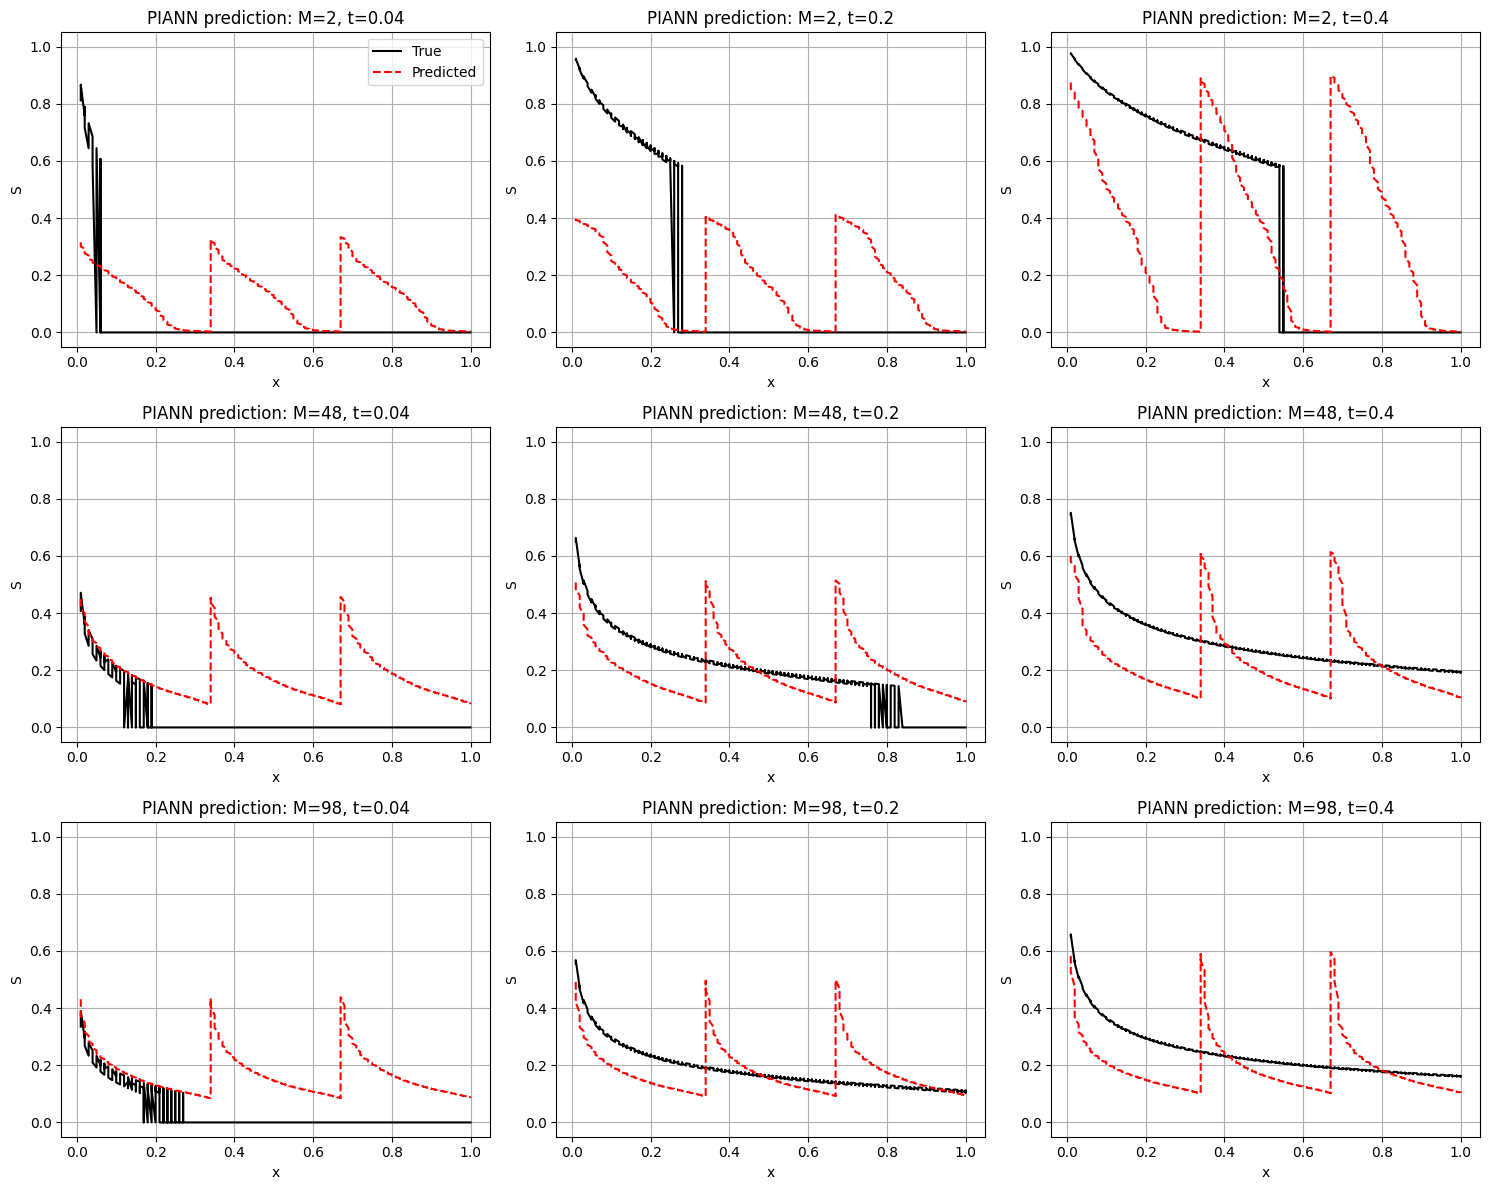

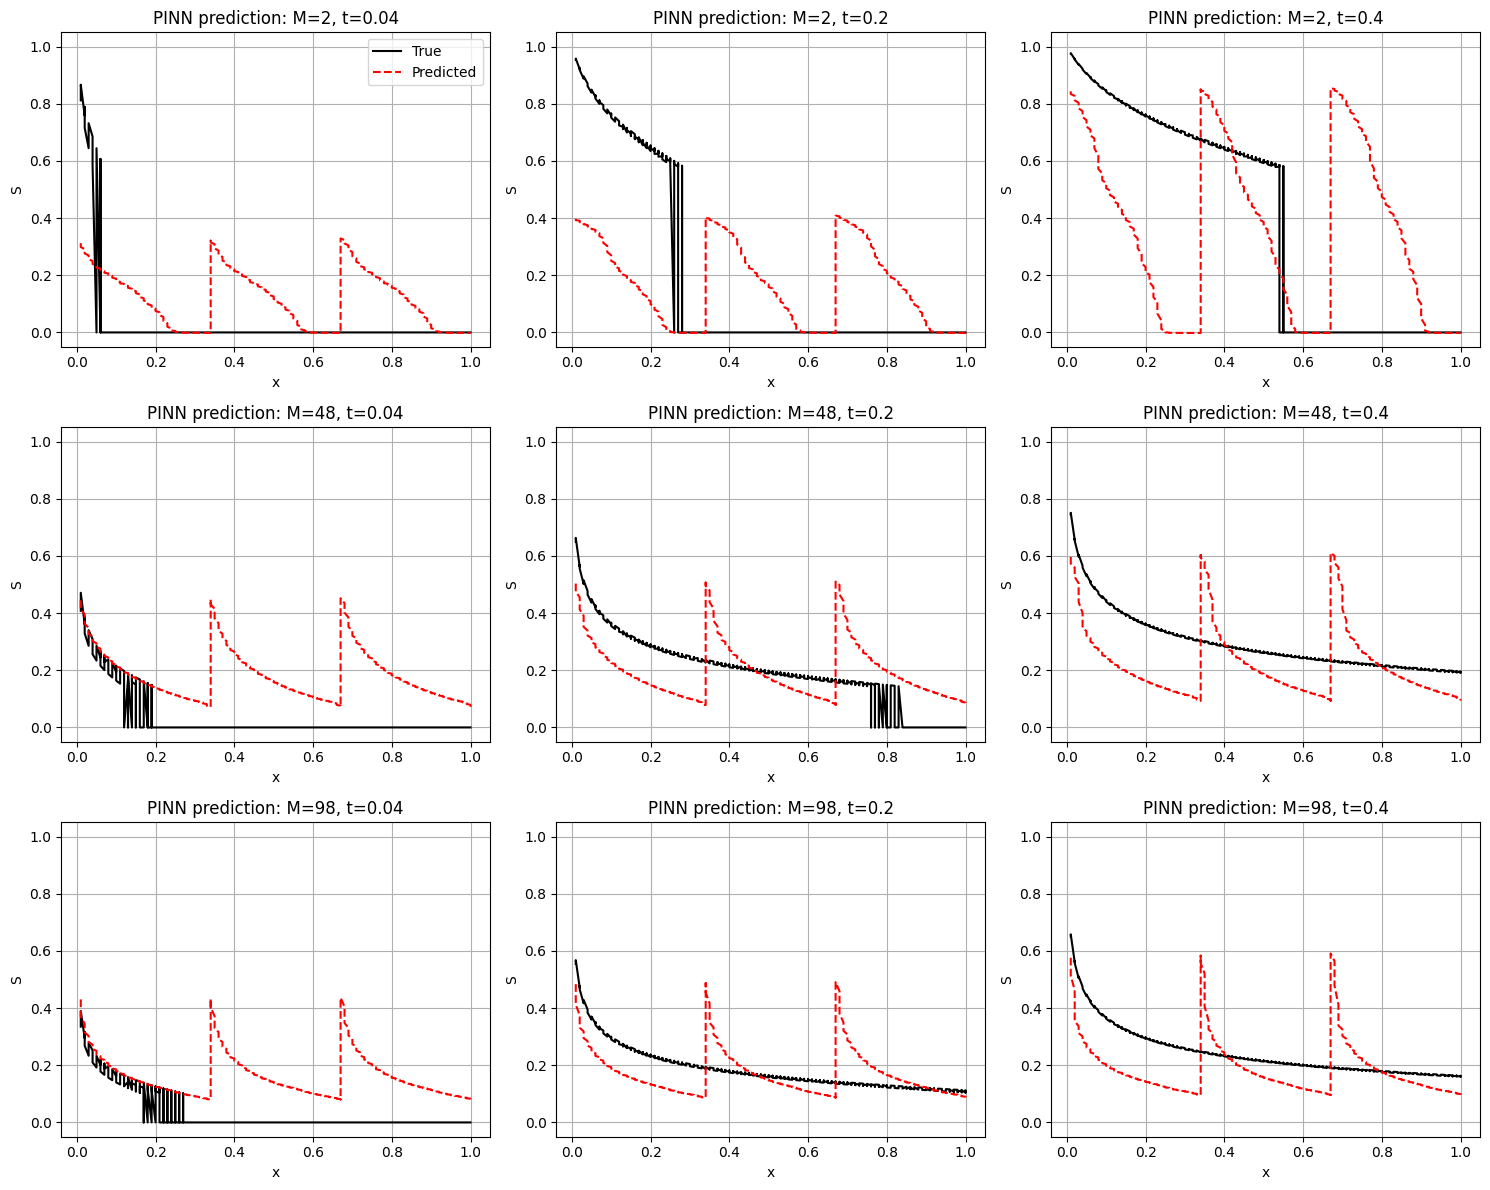

In [12]:
test_df['pred_pinn'] = pred_pinn.flatten()
test_df['pred_piann'] = pred_piann.flatten()

def plot_multislice_predictions(test_df, pred, M_vals, t_vals, model_name='Model prediction'):
    n_rows = len(M_vals)
    n_cols = len(t_vals)
    plt.figure(figsize=(5*n_cols, 4*n_rows))

    for i, M_val in enumerate(M_vals):
        for j, t_val in enumerate(t_vals):
            plt_idx = i*n_cols + j + 1
            plt.subplot(n_rows, n_cols, plt_idx)

            mask = (np.isclose(test_df['M'], M_val, atol=1.0)) & (np.isclose(test_df['t'], t_val, atol=0.01))
            df_plot = test_df[mask].sort_values('x')
            if df_plot.empty:
                plt.title(f"No data: M={M_val}, t={t_val}")
                plt.axis('off')
                continue

            plt.plot(df_plot['x'], df_plot['S'], color='black', label='True')
            plt.plot(df_plot['x'], pred[mask], 'r--', label='Predicted')

            plt.title(f"{model_name}: M={M_val}, t={t_val}")
            plt.xlabel('x')
            plt.ylabel('S')
            plt.ylim(-0.05, 1.05)
            plt.grid(True)
            if i == 0 and j == 0:
                plt.legend()

    plt.tight_layout()
    plt.show()

M_vals = [2, 48, 98]
t_vals = [0.04, 0.20, 0.40]

plot_multislice_predictions(test_df, pred_piann, M_vals, t_vals, model_name='PIANN prediction')
plot_multislice_predictions(test_df, pred_pinn, M_vals, t_vals, model_name='PINN prediction')

## https://colab.research.google.com/drive/1vBdYA9y8RnlvMeFBR32g6Uldf0Nok12p?usp=sharing